<a id="1"></a>
# Import libraries

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import plotly.graph_objs as go
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
import random
from tqdm.notebook import tqdm
from sklearn.metrics import f1_score
from torch.autograd import Variable
from albumentations import Compose, ShiftScaleRotate, ToFloat
from albumentations.pytorch import ToTensorV2
import cv2
import os
def set_seed(seed=0):
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    os.environ['PYTHONHASHSEED'] = str(seed)
set_seed(17)

In [2]:
class Plots:
    def __init__(self):
        pass

    def check_data(self, data):
        if not isinstance(data, pd.DataFrame) and not isinstance(data, pd.Series) and not isinstance(data, np.ndarray) and not isinstance(data, list) and not torch.is_tensor(data):
            raise TypeError('Wrong type of data. It should be pandas DataFrame, pandas Series, numpy array or torch tensor.')
        data = np.array(data)
        if(data.ndim == 2):
            data = data.squeeze()
        return data
    
    def check_2d_data(self, data):
        if not isinstance(data, pd.DataFrame) and not isinstance(data, pd.Series) and not isinstance(data, np.ndarray) and not torch.is_tensor(data):
            raise TypeError('Wrong type of data. It should be pandas DataFrame, pandas Series, numpy array or torch tensor.')
        return np.array(data)
    
    def barplot(self, data, name=""):
        data = self.check_data(data=data)
        data = list(data)
        fig = go.Figure()
        labels, frequency = np.unique(data, return_counts=True)
        fig.add_trace(go.Bar(x=labels, y=frequency, marker=dict(line=dict(color='black', width=1), color=frequency, colorscale='viridis'), text=frequency, textposition="inside"))
        fig.update_layout(template="simple_white", width=max(30*len(labels), 600), height=max(30*len(labels), 600), title=f"<b>Bar chart {name.title()}<b>", title_x=0.5, yaxis_title="Frequency", xaxis=dict(title=f'{name.title()}', showticklabels=True, type="category"), font=dict(family="Times New Roman",size=16,color="Black"))
        fig.show("png")
    
    def plot_lines(self, values1, values2, name1, name2, xaxis_title, yaxis_title, title):
        values1 = self.check_data(data=values1)
        values2 = self.check_data(data=values2)
        fig = go.Figure()
        fig.add_trace(go.Scatter(x=np.arange(1, len(values1)+1), y=values1, mode='lines+markers', name=f'{name1}', line=dict(color='blue', width=2)))
        fig.add_trace(go.Scatter(x=np.arange(1, len(values2)+1), y=values2, mode='lines+markers', name=f'{name2}', line=dict(color='orange', width=2)))
        fig.update_layout(template="simple_white", width=600, height=600, title=f"<b>{title}<b>", title_x=0.5, yaxis_title=f'{yaxis_title}', xaxis=dict(title=f'{xaxis_title}', showticklabels=True, type="category"), font=dict(family="Times New Roman",size=16,color="Black"))
        fig.show("png")
        
    
plots = Plots()

In [3]:
train_data = pd.read_csv('input/train.csv')
test_data = pd.read_csv('input/test.csv')

<a id="5"></a>
# Exploratory Data Analysis

In [4]:
count_of_missing=train_data.isna().sum(axis=1)
print("Percentage of observations with at least one missing value: {}%".format(np.round(100*len(count_of_missing[count_of_missing>0])/len(count_of_missing), 4)))
print("Percentage of missing values in whole dataset: {}%".format(np.round(100*count_of_missing.sum()/(len(train_data)*len(train_data.columns.tolist())), 4)))

Percentage of observations with at least one missing value: 0.0%
Percentage of missing values in whole dataset: 0.0%


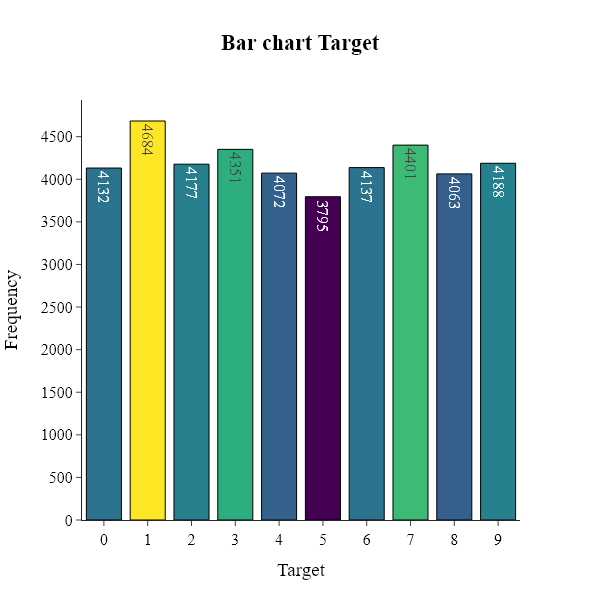

In [5]:
plots.barplot(data=train_data['label'], name="target")

<a id="5"></a>
# Data transformation

$\text{We perform a grayscale normalization to reduce the effect of illumination's differences.}$<p>
$\text{Moreover the CNN converge faster on [0..1] data than on [0..255].}$<p>
$\text{We will reshape image in 3 dimensions because currently they are stacked as 1D vectors of 784 values.}$<p>

In [6]:
def preprocessing(train, test, split_train_size = 0.2):
    
    # Split data into features(pixels) and labels(numbers from 0 to 9)
    y_train = train.label.values
    X_train = train.drop(["label"], axis = 1).values
    
    # Normalization
    X_train = X_train/255.
    X_test = test.values/255.
    
    #Convert to float64
    X_train = np.float32(X_train)
    X_test = np.float32(X_test)

    # Train test split. Size of train data is (1-split_train_size)*100% and size of test data is split_train_size%. 
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = split_train_size, random_state = 17, shuffle=True) 
    
    # Create feature and targets tensor for train set. I need variable to accumulate gradients. Therefore first I create tensor, then I will create variable
    X_train = torch.from_numpy(X_train)
    y_train = torch.from_numpy(y_train).type(torch.LongTensor) # data type is long

    # Create feature and targets tensor for test set.
    X_val = torch.from_numpy(X_val)
    y_val = torch.from_numpy(y_val).type(torch.LongTensor) # data type is long
    
    # Create feature tensor for train set.
    X_test = torch.from_numpy(X_test)
    
    return X_train, y_train, X_val, y_val, X_test
X_train, y_train, X_val, y_val, X_test = preprocessing(train_data, test_data)

In [7]:
print(f'Shape of training data: {X_train.shape}')
print(f'Shape training labels: {y_train.shape}')
print(f'Shape of validation data: {X_val.shape}')
print(f'Shape of valiation labels: {y_val.shape}')
print(f'Shape of testing data: {X_test.shape}')

Shape of training data: torch.Size([33600, 784])
Shape training labels: torch.Size([33600])
Shape of validation data: torch.Size([8400, 784])
Shape of valiation labels: torch.Size([8400])
Shape of testing data: torch.Size([28000, 784])


In [8]:
BATCH_SIZE = 16
EPOCHS = 200
LEARNING_RATE = 1e-5
train_tensor = torch.utils.data.TensorDataset(X_train, y_train)
val_tensor = torch.utils.data.TensorDataset(X_val, y_val)
test_tensor = torch.utils.data.TensorDataset(X_test)
train_loader = torch.utils.data.DataLoader(train_tensor, batch_size = BATCH_SIZE, shuffle = False)
val_loader = torch.utils.data.DataLoader(val_tensor, batch_size = BATCH_SIZE, shuffle = False)
test_loader = torch.utils.data.DataLoader(test_tensor, batch_size = BATCH_SIZE, shuffle = False)

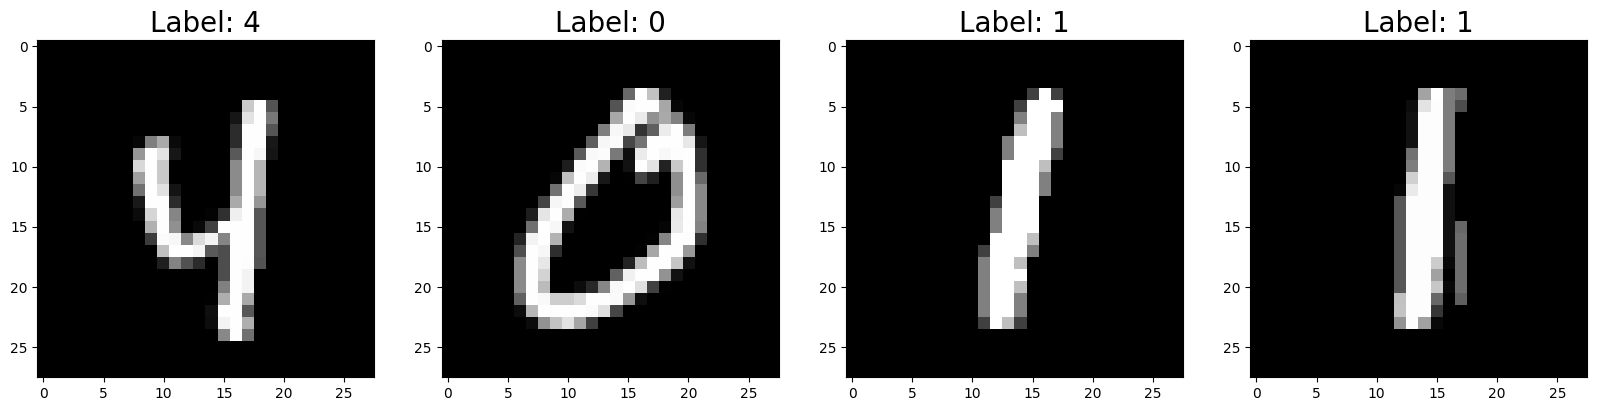

In [9]:
plt.figure(figsize=(20,20))
for index, (image, label) in enumerate(zip(X_train[0:4], y_train[0:4])):
    image = image.detach().cpu().numpy()
    plt.subplot(1, 4, index + 1)
    plt.imshow(np.reshape(image, (28,28)), cmap=plt.cm.gray)
    plt.title(f'Label: {label}', fontsize = 20)

<a id="5"></a>
# Modelling

In [12]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 32, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 32, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.25)
        )
        
        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 64, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.25)
        )
        
        self.conv3 = nn.Sequential(
            nn.Conv2d(64, 128, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.25)
        )
        
        self.fc = nn.Sequential(
            nn.Linear(128, 10)
        )
                
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        print(x.shape)
        x = x.view(x.size(0), -1)
        print(x.shape)
        x = self.fc(x)
        x = F.log_softmax(x, dim=1)
        return x

In [13]:
model = Model()
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, eps=1e-8, weight_decay=0.01)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.99, verbose=False)
criterion = nn.CrossEntropyLoss()
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = float('inf')

    def early_stop(self, validation_loss):
        if(validation_loss < self.min_validation_loss):
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif(validation_loss >= (self.min_validation_loss + self.min_delta)):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False
early_stopper = EarlyStopping(patience=5, min_delta=0)
if torch.cuda.is_available():
    print("Model will be training on GPU: {}".format(torch.cuda.get_device_name(0)))
    model = model.cuda()
    criterion = criterion.cuda()
else:
    print("Model will be training on CPU")

Model will be training on GPU: NVIDIA GeForce RTX 3060


C:\Users\Kuba\AppData\Roaming\Python\Python311\site-packages\torch\optim\lr_scheduler.py:28: UserWarning:

The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.



In [14]:
def f1_score_func(preds, labels):
    labels_flat = labels.flatten()
    preds = np.argmax(preds, axis=1).flatten()
    return f1_score(labels_flat, preds, average='weighted')

def evaluate(dataloader):
    model.eval()
    loss_total = 0
    predictions = torch.LongTensor()
    if torch.cuda.is_available():
        predictions = predictions.cuda()
    with torch.no_grad():
        for batch_idx, (inputs, labels) in enumerate(dataloader):
            inputs, labels = Variable(inputs.view(BATCH_SIZE, 1, 28, 28)), Variable(labels)
            if torch.cuda.is_available():
                inputs = inputs.cuda()
                labels = labels.cuda()
            output = model(inputs)
            loss = criterion(output, labels)
            loss_total += loss.item()
            predictions = torch.cat((predictions, output), dim=0)
    loss_avg = loss_total/len(dataloader)
    return predictions.detach().cpu().numpy(), loss_avg

def predict(dataloader):
    model.eval()
    predictions = torch.LongTensor()
    if torch.cuda.is_available():
        predictions = predictions.cuda()
    with torch.no_grad():
        for batch_idx, inputs in enumerate(dataloader):
            inputs = Variable(inputs.view(BATCH_SIZE, 1, 28, 28))
            if torch.cuda.is_available():
                inputs = inputs.cuda()
            output = model(inputs)
            predictions = torch.cat((predictions, output), dim=0)
    return predictions.detach().cpu().numpy()
    
def train(train_loader, val_loader, epochs):
    train_losses, valid_losses = [], []
    train_scores, valid_scores = [], []
    train_true_vals = torch.cat([labels for batch_idx, (inputs, labels) in enumerate(train_loader)]).cpu().numpy()
    valid_true_vals = torch.cat([labels for batch_idx, (inputs, labels) in enumerate(val_loader)]).cpu().numpy()
    for epoch in tqdm(range(1, epochs+1)):
        model.train()
        loss_train_total = 0
        progress_bar = tqdm(train_loader, desc='Epoch {:1d}'.format(epoch), leave=True)
        for batch_idx, (inputs, labels) in enumerate(progress_bar):
            inputs, labels = Variable(inputs.view(BATCH_SIZE,1,28,28)), Variable(labels)
            if torch.cuda.is_available():
                inputs = inputs.cuda()
                labels = labels.cuda()
            optimizer.zero_grad()
            output = model(inputs)
            loss = criterion(output, labels)
            loss_train_total += loss.item()
            loss.backward()
            optimizer.step()
            progress_bar.set_postfix({'Training loss': '{:.3f}'.format(loss.item()/len(inputs))})
        before_lr = optimizer.param_groups[0]["lr"]
        #torch.save(model.state_dict(), 'saved_models/temp_best_model.pth')
        tqdm.write(f'\nEpoch {epoch}')
        tqdm.write(f'Training loss: {loss_train_total/len(train_loader)}')
        train_predictions, _ = evaluate(dataloader=train_loader)
        train_f1 = f1_score_func(train_predictions, train_true_vals)
        tqdm.write(f'Training F1-score: {train_f1}')
        valid_predictions, valid_loss_avg = evaluate(dataloader=val_loader)
        valid_f1 = f1_score_func(valid_predictions, valid_true_vals)
        tqdm.write(f'Validation loss: {valid_loss_avg}')
        tqdm.write(f'Validation F1-score: {valid_f1}')
        scheduler.step()
        tqdm.write(f'Learning rate: {before_lr} -> {optimizer.param_groups[0]["lr"]}')
        train_losses.append(loss_train_total/len(train_loader))
        valid_losses.append(valid_loss_avg)
        train_scores.append(train_f1)
        valid_scores.append(valid_f1)
        if early_stopper.early_stop(valid_loss_avg):
            tqdm.write("Stopped early at epoch {} due to no improvement in validation loss.".format(epoch))
            break
    return train_losses, valid_losses, train_scores, valid_scores
train_losses, valid_losses, train_scores, valid_scores = train(train_loader=train_loader, val_loader=val_loader, epochs = EPOCHS)

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/2100 [00:00<?, ?it/s]

torch.Size([16, 128, 1, 1])
torch.Size([16, 128])
torch.Size([16, 128, 1, 1])
torch.Size([16, 128])
torch.Size([16, 128, 1, 1])
torch.Size([16, 128])
torch.Size([16, 128, 1, 1])
torch.Size([16, 128])
torch.Size([16, 128, 1, 1])
torch.Size([16, 128])
torch.Size([16, 128, 1, 1])
torch.Size([16, 128])
torch.Size([16, 128, 1, 1])
torch.Size([16, 128])
torch.Size([16, 128, 1, 1])
torch.Size([16, 128])
torch.Size([16, 128, 1, 1])
torch.Size([16, 128])
torch.Size([16, 128, 1, 1])
torch.Size([16, 128])
torch.Size([16, 128, 1, 1])
torch.Size([16, 128])
torch.Size([16, 128, 1, 1])
torch.Size([16, 128])
torch.Size([16, 128, 1, 1])
torch.Size([16, 128])
torch.Size([16, 128, 1, 1])
torch.Size([16, 128])
torch.Size([16, 128, 1, 1])
torch.Size([16, 128])
torch.Size([16, 128, 1, 1])
torch.Size([16, 128])
torch.Size([16, 128, 1, 1])
torch.Size([16, 128])
torch.Size([16, 128, 1, 1])
torch.Size([16, 128])
torch.Size([16, 128, 1, 1])
torch.Size([16, 128])
torch.Size([16, 128, 1, 1])
torch.Size([16, 128])


KeyboardInterrupt: 

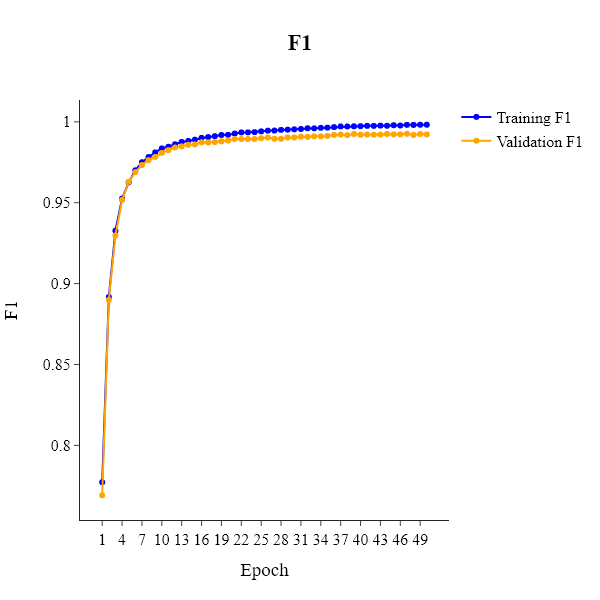

In [13]:
plots.plot_lines(values1=train_scores, values2=valid_scores, name1="Training F1", name2="Validation F1", xaxis_title="Epoch", yaxis_title="F1", title="F1")

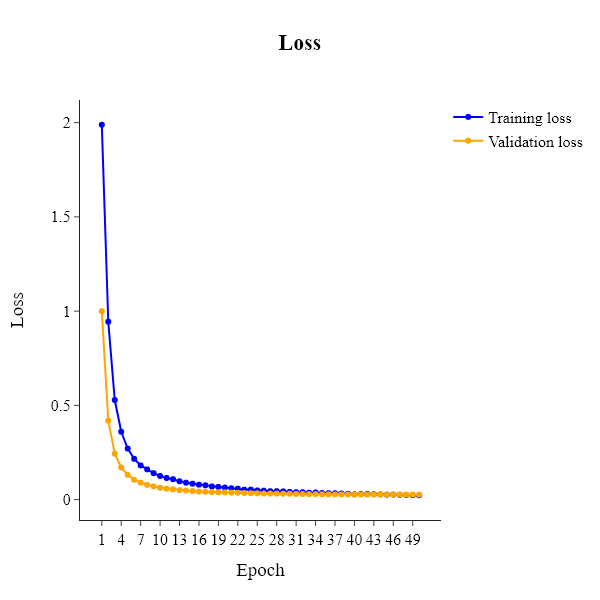

In [14]:
plots.plot_lines(values1=train_losses, values2=valid_losses, name1="Training loss", name2="Validation loss", xaxis_title="Epoch", yaxis_title="Loss", title="Loss")

<h1>Augmentation<h1>

$\text{We will perform image augmentation to get some more data for training.}$<p>
$\text{Results will be compared to this received by training on standard dataset.}$

In [15]:
train_data = pd.read_csv('input/train.csv')
test_data = pd.read_csv('input/test.csv')

In [16]:
def preprocessing_augmentation(train, test, split_train_size = 0.2):
    
    # Split data into features(pixels) and labels(numbers from 0 to 9)
    y_train = train.label.values
    X_train = train.drop(["label"], axis = 1).values.reshape(-1, 28, 28, 1)
    
    # Normalization
    X_train = X_train/255.
    X_test = test.values.reshape(-1, 28, 28, 1)/255.
    
    #Convert to float64
    X_train = np.float32(X_train)
    X_test = np.float32(X_test)

    # Train test split. Size of train data is (1-split_train_size)*100% and size of test data is split_train_size%. 
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = split_train_size, random_state = 17, shuffle=True) 
    
    # Create feature and targets tensor for train set. I need variable to accumulate gradients. Therefore first I create tensor, then I will create variable
    X_train = torch.from_numpy(X_train)
    y_train = torch.from_numpy(y_train).type(torch.LongTensor) # data type is long

    # Create feature and targets tensor for test set.
    X_val = torch.from_numpy(X_val)
    y_val = torch.from_numpy(y_val).type(torch.LongTensor) # data type is long
    
    # Create feature tensor for train set.
    X_test = torch.from_numpy(X_test)
    
    return X_train, y_train, X_val, y_val, X_test
X_train, y_train, X_val, y_val, X_test = preprocessing_augmentation(train_data, test_data)

In [17]:
class AugmentedDataset(Dataset):
    def __init__(self, X, y, is_test=False, transforms=None):
        self.X = X
        self.y = y
        self.is_test = is_test
        self.transforms = transforms
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        image = self.X[idx]
        if self.transforms:
            image = self.transforms(image=image)['image']
        #Return normal image and transformed image if it is train dataset
        if self.is_test:
            return image
        else:
            return image, self.y[idx]

In [18]:
train_transforms = Compose([ToFloat(max_value=1), 
                            ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=10, border_mode=cv2.BORDER_CONSTANT, value=0, p=1),
                            ToTensorV2()])
valid_transforms = Compose([ToFloat(max_value=1),
                            ToTensorV2()])

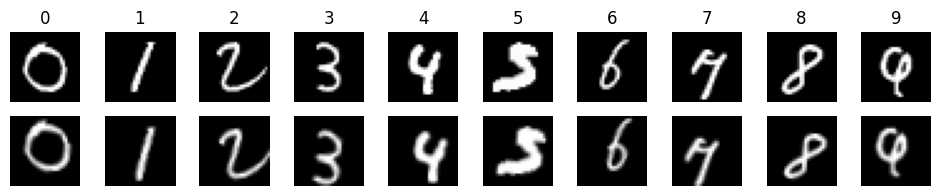

In [19]:
def display_transformations(transforms):
    fig = plt.figure(figsize=(12, 2))
    for k in range(10):
        idx = random.choice(train_data.label[train_data.label.eq(k)].index)
        image, label = train_data.drop(columns='label').iloc[idx].values.reshape(28, 28), k

        ax = plt.subplot(2, 10, k+1)
        ax.title.set_text(label)
        plt.axis('off')
        plt.imshow(image, cmap='gray')

        image = np.expand_dims(image, 2)
        image = transforms(image=image)['image']
        image = image.squeeze(0)
        ax = plt.subplot(2, 10, 10+k+1)
        plt.axis('off')
        plt.imshow(image, cmap='gray')
display_transformations(train_transforms)

In [20]:
datasets = []
for i in range(0, 10):
    datasets.append(AugmentedDataset(X=X_train.detach().numpy(), y=y_train, transforms=train_transforms))
train_dataset = torch.utils.data.ConcatDataset(datasets)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False)
val_dataset = AugmentedDataset(X=X_val.detach().numpy(), y=y_val, transforms=valid_transforms)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_dataset = AugmentedDataset(X=X_test.detach().numpy(), y=None, is_test=True, transforms=valid_transforms)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [21]:
model = Model()
optimizer = optim.AdamW(model.parameters(), lr=1e-5, eps=1e-8, weight_decay=0.01)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.99, verbose=False)
criterion = nn.CrossEntropyLoss()
early_stopper = EarlyStopping(patience=5, min_delta=0)
if torch.cuda.is_available():
    print("Model will be training on GPU: {}".format(torch.cuda.get_device_name(0)))
    model = model.cuda()
    criterion = criterion.cuda()
else:
    print("Model will be training on CPU")

Model will be training on GPU: NVIDIA GeForce RTX 3060


In [22]:
train_losses, valid_losses, train_scores, valid_scores = train(train_loader=train_loader, val_loader=val_loader, epochs = EPOCHS)

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/21000 [00:00<?, ?it/s]


Epoch 1
Training loss: 0.7449491507635851
Training F1-score: 0.9710470961057193
Validation loss: 0.06371274975826964
Validation F1-score: 0.9805973794780911
Learning rate: 1e-05 -> 9.9e-06


Epoch 2:   0%|          | 0/21000 [00:00<?, ?it/s]


Epoch 2
Training loss: 0.1368656848661402
Training F1-score: 0.9845288829190474
Validation loss: 0.035282394740913464
Validation F1-score: 0.9877417655510243
Learning rate: 9.9e-06 -> 9.801e-06


Epoch 3:   0%|          | 0/21000 [00:00<?, ?it/s]


Epoch 3
Training loss: 0.08769442174648256
Training F1-score: 0.9886315765740837
Validation loss: 0.027695053607763146
Validation F1-score: 0.9911927864186719
Learning rate: 9.801e-06 -> 9.70299e-06


Epoch 4:   0%|          | 0/21000 [00:00<?, ?it/s]


Epoch 4
Training loss: 0.06781918459476548
Training F1-score: 0.9905106269333798
Validation loss: 0.024138988747352933
Validation F1-score: 0.9923814584937654
Learning rate: 9.70299e-06 -> 9.6059601e-06


Epoch 5:   0%|          | 0/21000 [00:00<?, ?it/s]


Epoch 5
Training loss: 0.05682141888714423
Training F1-score: 0.9921588292343884
Validation loss: 0.022228792731919036
Validation F1-score: 0.9933371147279909
Learning rate: 9.6059601e-06 -> 9.509900499e-06


Epoch 6:   0%|          | 0/21000 [00:00<?, ?it/s]


Epoch 6
Training loss: 0.048706591903397656
Training F1-score: 0.9930250726031026
Validation loss: 0.020126607683750557
Validation F1-score: 0.9936918855854644
Learning rate: 9.509900499e-06 -> 9.414801494009999e-06


Epoch 7:   0%|          | 0/21000 [00:00<?, ?it/s]


Epoch 7
Training loss: 0.04288589460197129
Training F1-score: 0.9940104824118144
Validation loss: 0.01942583943848842
Validation F1-score: 0.9944046556443661
Learning rate: 9.414801494009999e-06 -> 9.320653479069899e-06


Epoch 8:   0%|          | 0/21000 [00:00<?, ?it/s]


Epoch 8
Training loss: 0.038687571594225506
Training F1-score: 0.9945698609325503
Validation loss: 0.018935880871109215
Validation F1-score: 0.9942864010222215
Learning rate: 9.320653479069899e-06 -> 9.227446944279199e-06


Epoch 9:   0%|          | 0/21000 [00:00<?, ?it/s]


Epoch 9
Training loss: 0.03530974876258898
Training F1-score: 0.9949158109635734
Validation loss: 0.018169330101223923
Validation F1-score: 0.9952396223257617
Learning rate: 9.227446944279199e-06 -> 9.135172474836406e-06


Epoch 10:   0%|          | 0/21000 [00:00<?, ?it/s]


Epoch 10
Training loss: 0.03247246785374799
Training F1-score: 0.9954940480767381
Validation loss: 0.018359054495842776
Validation F1-score: 0.9942881124193578
Learning rate: 9.135172474836406e-06 -> 9.043820750088042e-06


Epoch 11:   0%|          | 0/21000 [00:00<?, ?it/s]


Epoch 11
Training loss: 0.030327085215978426
Training F1-score: 0.9955081395845279
Validation loss: 0.01890206713413742
Validation F1-score: 0.9948828607734068
Learning rate: 9.043820750088042e-06 -> 8.953382542587162e-06


Epoch 12:   0%|          | 0/21000 [00:00<?, ?it/s]


Epoch 12
Training loss: 0.027927388432207365
Training F1-score: 0.9959250804590982
Validation loss: 0.01817697566887416
Validation F1-score: 0.9946439461228515
Learning rate: 8.953382542587162e-06 -> 8.86384871716129e-06


Epoch 13:   0%|          | 0/21000 [00:00<?, ?it/s]


Epoch 13
Training loss: 0.026385325247305098
Training F1-score: 0.9962018111650428
Validation loss: 0.01761410396956351
Validation F1-score: 0.9945255951182378
Learning rate: 8.86384871716129e-06 -> 8.775210229989677e-06


Epoch 14:   0%|          | 0/21000 [00:00<?, ?it/s]


Epoch 14
Training loss: 0.02467250341757054
Training F1-score: 0.9964580183002637
Validation loss: 0.017013515198099672
Validation F1-score: 0.9952395575634808
Learning rate: 8.775210229989677e-06 -> 8.68745812768978e-06


Epoch 15:   0%|          | 0/21000 [00:00<?, ?it/s]


Epoch 15
Training loss: 0.02308144806137456
Training F1-score: 0.9966483459253378
Validation loss: 0.01774566419264894
Validation F1-score: 0.9948825130374434
Learning rate: 8.68745812768978e-06 -> 8.60058354641288e-06


Epoch 16:   0%|          | 0/21000 [00:00<?, ?it/s]


Epoch 16
Training loss: 0.021916219881351676
Training F1-score: 0.9966036366350239
Validation loss: 0.017961031722910168
Validation F1-score: 0.9945259102398748
Learning rate: 8.60058354641288e-06 -> 8.514577710948753e-06


Epoch 17:   0%|          | 0/21000 [00:00<?, ?it/s]


Epoch 17
Training loss: 0.0207427937534368
Training F1-score: 0.9970055383320796
Validation loss: 0.016791675816876662
Validation F1-score: 0.9953577056584488
Learning rate: 8.514577710948753e-06 -> 8.429431933839265e-06


Epoch 18:   0%|          | 0/21000 [00:00<?, ?it/s]


Epoch 18
Training loss: 0.020421715211487026
Training F1-score: 0.9971694311890297
Validation loss: 0.017743210634801342
Validation F1-score: 0.9948820470612578
Learning rate: 8.429431933839265e-06 -> 8.345137614500872e-06


Epoch 19:   0%|          | 0/21000 [00:00<?, ?it/s]


Epoch 19
Training loss: 0.018990171100159516
Training F1-score: 0.997196229058622
Validation loss: 0.017660873198300623
Validation F1-score: 0.9953573528847223
Learning rate: 8.345137614500872e-06 -> 8.261686238355863e-06


Epoch 20:   0%|          | 0/21000 [00:00<?, ?it/s]


Epoch 20
Training loss: 0.01835108717716321
Training F1-score: 0.9974908635821444
Validation loss: 0.018134513754484077
Validation F1-score: 0.9948823570052242
Learning rate: 8.261686238355863e-06 -> 8.179069375972305e-06


Epoch 21:   0%|          | 0/21000 [00:00<?, ?it/s]


Epoch 21
Training loss: 0.0173752868846964
Training F1-score: 0.9976219307269766
Validation loss: 0.017025316424131104
Validation F1-score: 0.9955972841317087
Learning rate: 8.179069375972305e-06 -> 8.097278682212583e-06


Epoch 22:   0%|          | 0/21000 [00:00<?, ?it/s]


Epoch 22
Training loss: 0.017014810376312414
Training F1-score: 0.997788613390655
Validation loss: 0.017023922718863105
Validation F1-score: 0.9950017449916996
Learning rate: 8.097278682212583e-06 -> 8.016305895390456e-06
Stopped early at epoch 22 due to no improvement in validation loss.


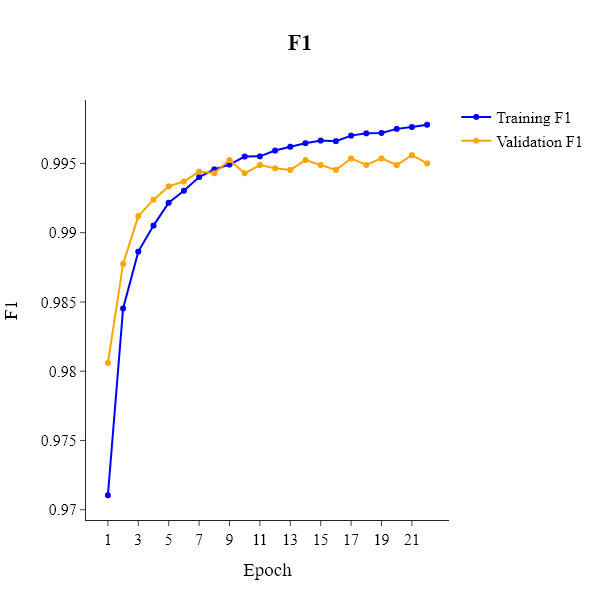

In [23]:
plots.plot_lines(values1=train_scores, values2=valid_scores, name1="Training F1", name2="Validation F1", xaxis_title="Epoch", yaxis_title="F1", title="F1")

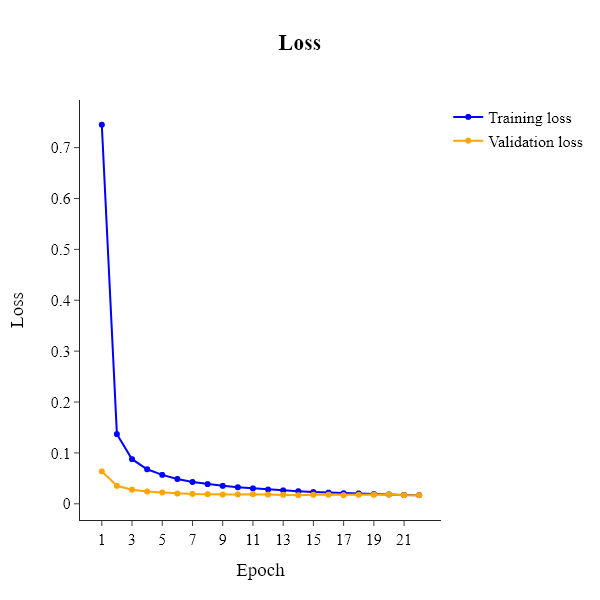

In [24]:
plots.plot_lines(values1=train_losses, values2=valid_losses, name1="Training loss", name2="Validation loss", xaxis_title="Epoch", yaxis_title="Loss", title="Loss")

<h3>Wrongly assigned labels<h3>

$\text{Check some of the wrong predictions on validation dataset.}$

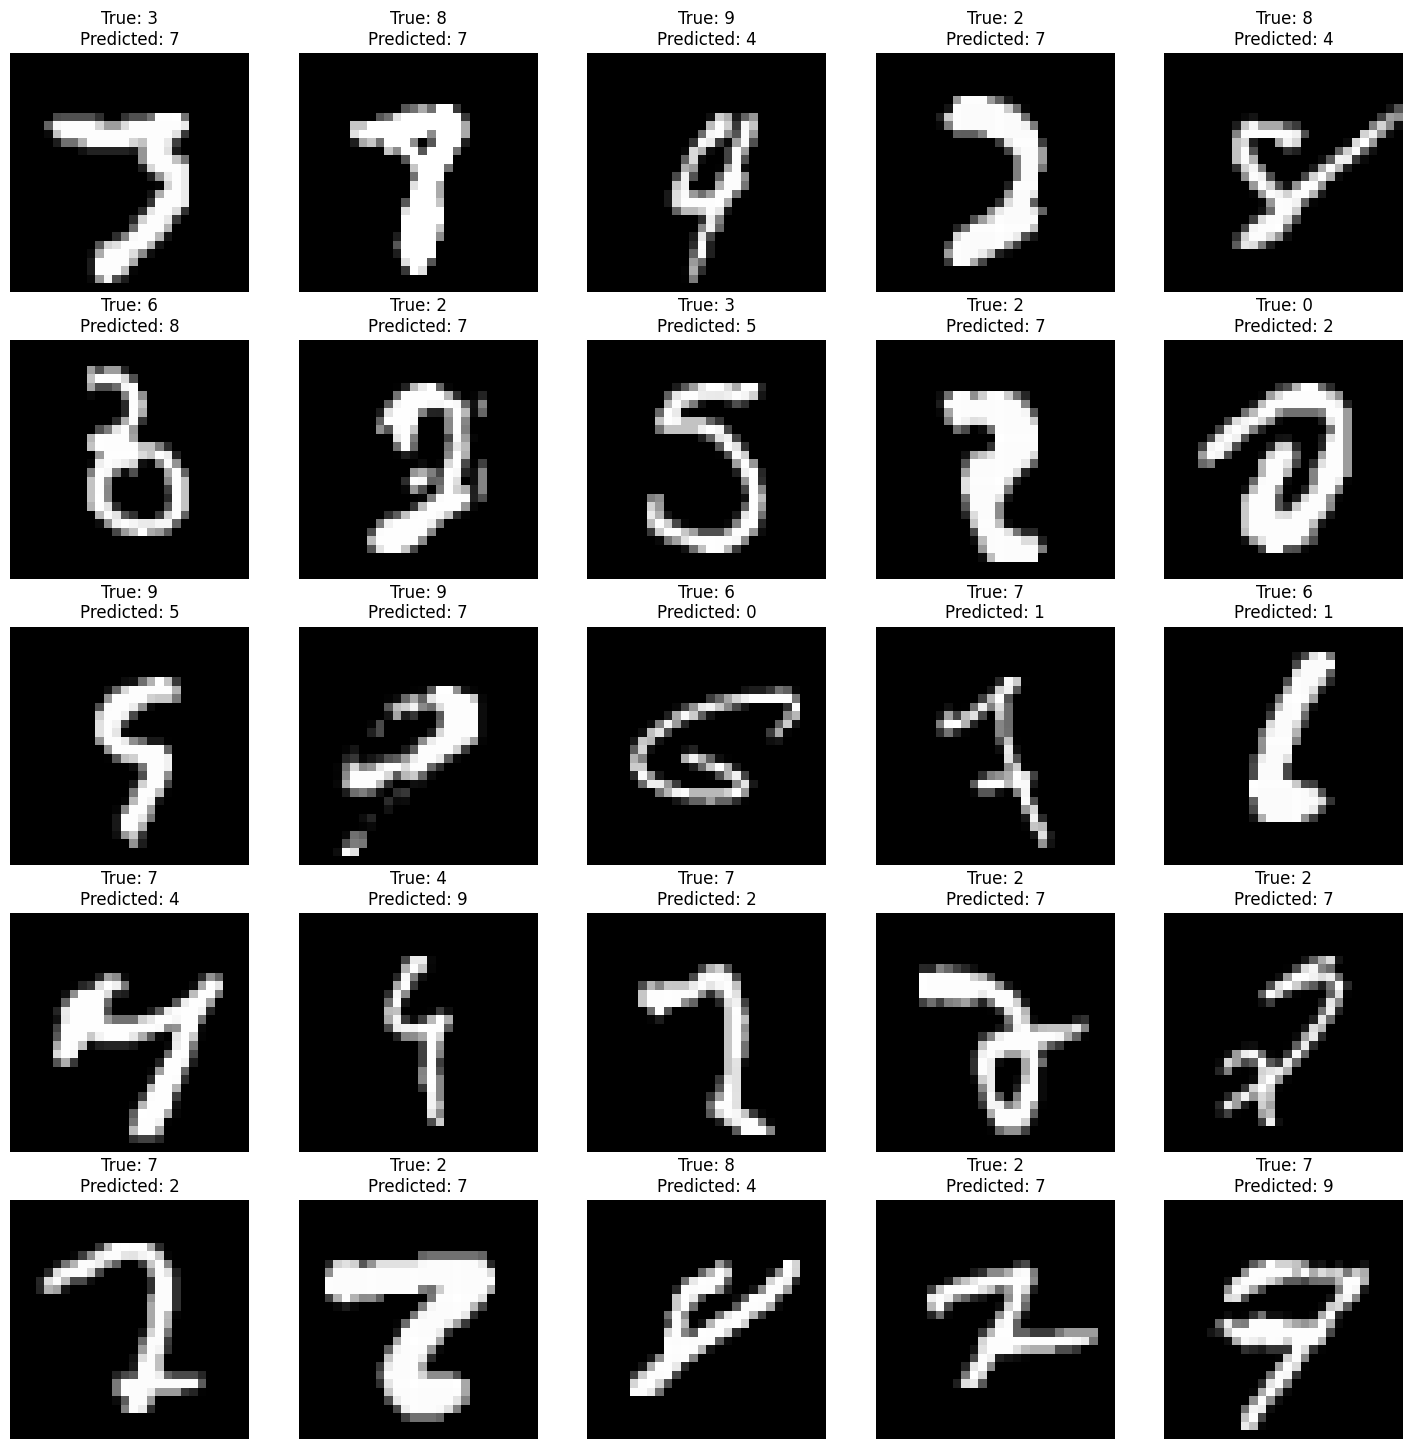

In [25]:
predictions, _ = evaluate(dataloader=val_loader)
predictions = np.argmax(predictions, axis=1)
val_true_vals = y_val.cpu().numpy()
wrong_predictions = X_val[val_true_vals != predictions]
wrong_true_vals = val_true_vals[val_true_vals != predictions]
wrong_predictions = wrong_predictions.cpu().numpy()
wrong_predictions = wrong_predictions.reshape(-1, 28, 28)
wrong_predictions = wrong_predictions*255
wrong_predictions = wrong_predictions.astype(np.uint8)
wrong_true_vals = wrong_true_vals.astype(np.uint8)
fig = plt.figure(figsize=(18, 18))
for k in range(0, 25):
    ax = plt.subplot(5, 5, k+1)
    plt.axis('off')
    plt.imshow(wrong_predictions[k], cmap='gray')
    ax.title.set_text(f'True: {wrong_true_vals[k]}\nPredicted: {predictions[val_true_vals != predictions][k]}')
plt.show()

<h1>Predictions<h1>

In [26]:
predictions = predict(test_loader)
predictions = np.argmax(predictions, axis=1)
predictions = pd.Series(predictions, name="Label")
submission = pd.concat([pd.Series(range(1,28001),name = "ImageId"), predictions], axis = 1)

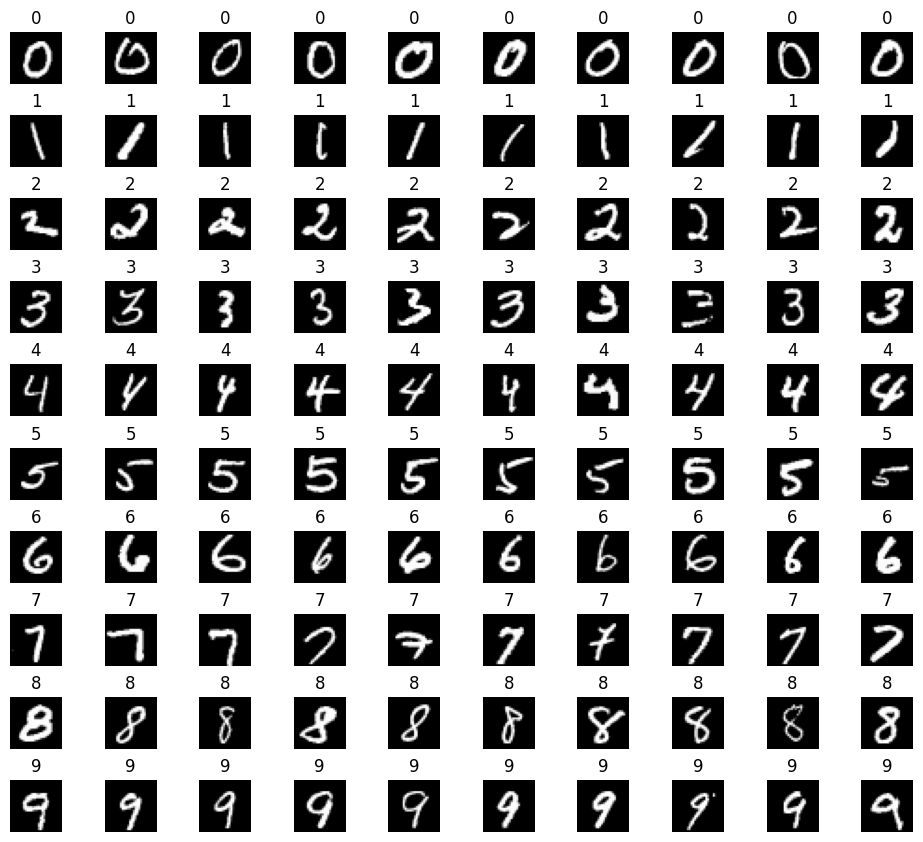

In [27]:
fig = plt.figure(figsize=(12, 10))
for k in range(10):
    indices = submission[submission.Label.eq(k)].sample(10).index
    for j, idx in enumerate(indices):
        image, label = X_test[idx], submission.loc[idx, 'Label'].item()
        image = image.squeeze(2)
        ax = plt.subplot(10, 10, 10*k+j+1)
        ax.title.set_text(label)
        plt.axis('off')
        plt.imshow(image, cmap='gray')
plt.subplots_adjust(left=0.125, bottom=0.1, right=0.9, top=0.9, wspace=0.2, hspace=0.6)

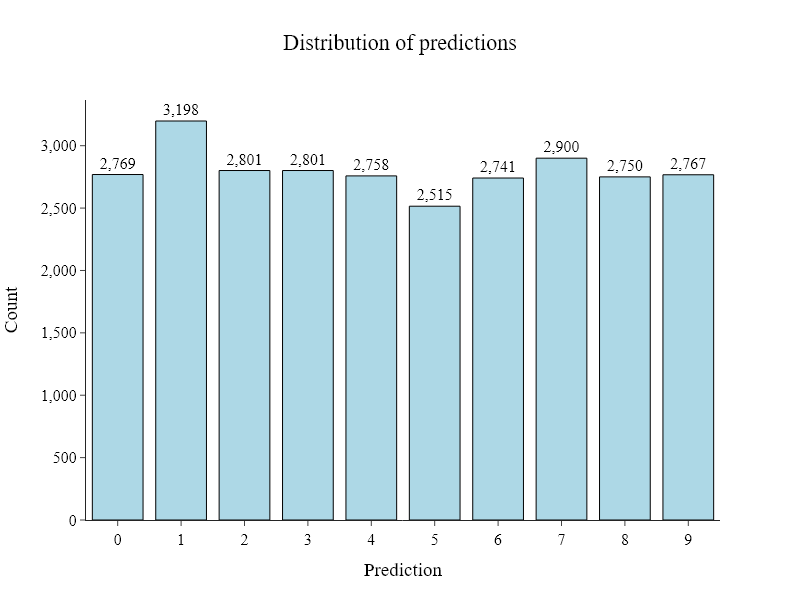

In [28]:
prediction_counts = submission.Label.value_counts().to_frame().reset_index().rename(columns={'Label': 'Prediction', 'count': 'Count'}).sort_values('Prediction')
fig = go.Figure()
fig.add_trace(go.Bar(x=prediction_counts.Prediction, y=prediction_counts.Count, marker=dict(line=dict(color='black', width=1), color="lightblue"), text=prediction_counts.Count, textposition="outside"))
fig.update_traces(textposition='outside', texttemplate='%{y}',cliponaxis=False,hovertemplate='Prediction: <b>%{x}</b><br>'+'Count: <b>%{y}</b>')
fig.update_layout(title='Distribution of predictions', yaxis_title='Count', xaxis_title='Prediction', xaxis_type='category', yaxis_tickformat=',', hoverlabel_bgcolor="white", hoverlabel_font_size=14, hovermode="x", template="simple_white", width=800, height=600, title_x=0.5, font=dict(family="Times New Roman",size=16,color="Black"))
fig.show("png")